In [1]:
import numpy as np
import pandas as pd  
import random as rnd
import math
import os
import glob
from itertools import product, combinations
from IPython.display import display, HTML
from tqdm import tqdm_notebook
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch
from torch import nn
from torch.utils.data import DataLoader
from utils import project, NPR, MF2PCA2ORIG, cross_val_score_custom
import multiprocessing
%matplotlib inline

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, NeighborhoodComponentsAnalysis
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, KFold
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE, MDS, SpectralEmbedding
from sklearn.decomposition import PCA

from ray import tune
import hyperopt as hp
from ray.tune.suggest.hyperopt import HyperOptSearch

In [17]:
EPS = 1e-10

def mae_score(y, y_pred):
    N = y.shape[0]
    eps = np.ones((N))*EPS
    denominator =  np.max(np.stack([np.linalg.norm(y, axis=1, ord=1), eps], 1), 1)
    return (np.linalg.norm(y_pred - y, axis=1, ord=1) / denominator).mean()

def mae_score_torch(y, y_pred):
    N = y.shape[0]
    eps = torch.ones(N, device=y.device)*EPS
    denominator =  torch.max(torch.stack([torch.norm(y, dim=1, p=1), eps], 1), 1)[0]
    return (torch.norm(y_pred - y, dim=1, p=1) / denominator).mean()

scorer_mae = make_scorer(mae_score, greater_is_better=False)

In [3]:
datasets_nums = {'AGP':9511, 'ptb':3457, 't2d':1044, 'ibd':86}

In [4]:
MERGED = True
SAVE = True

if MERGED:
    root = './merged_datasets_proj/'
    intrinsic_dims = np.load('intrinsic_dims_merged.npy', allow_pickle=True).item()
else:
    root = './separate_datasets_proj/'
    intrinsic_dims = np.load('intrinsic_dims_separate.npy', allow_pickle=True).item()

# Model

In [18]:
class AE(nn.Module):
    def __init__(self, input_dim, z_dim, config):
        hidden_dim = config['hidden_dim']
        dropout_rate1 = config['dropout_rate1']
        dropout_rate2 = config['dropout_rate2']
        dropout_rate3 = config['dropout_rate3']
        dropout_rate4 = config['dropout_rate4']
        
        dropout_rate5 = config['dropout_rate5']
        dropout_rate6 = config['dropout_rate6']
        dropout_rate7 = config['dropout_rate7']
        dropout_rate8 = config['dropout_rate8']
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate1),
                                     
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate2), 
                                     
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.BatchNorm1d(hidden_dim//2), 
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate3),
                                     
                                    nn.Linear(hidden_dim//2, hidden_dim//4),
                                    nn.BatchNorm1d(hidden_dim//4),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate4), 
                                    nn.Linear(hidden_dim//4, z_dim))
        
        self.decoder = nn.Sequential(nn.Linear(z_dim, hidden_dim//4),
                                    nn.BatchNorm1d(hidden_dim//4),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate5),
                                     
                                    nn.Linear(hidden_dim//4, hidden_dim//2),
                                    nn.BatchNorm1d(hidden_dim//2),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate6), 
                                     
                                    nn.Linear(hidden_dim//2, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim), 
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate7),
                                     
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate8), 
                                    nn.Linear(hidden_dim, input_dim))
    def forward(self, X):
        z = self.encoder(X)
        X = self.decoder(z)
        return z,X


In [19]:
def train_ae(data_train, 
             data_test, 
             dim_range,
             config,
             n_epochs=6000,
             batch_size=256,
             validate=True,
             calc_npr=True, 
             npr_calc_step=100,
             calc_pdist=False,
             pdist_calc_step=500,
             return_history=True):
    
    min_loss_val_dim = []
    if return_history:
        results = defaultdict(list)
        metrics_dict = defaultdict(dict)
        
    data_proj_train_torch = torch.tensor(data_train, dtype=torch.float).cuda()
    data_proj_test_torch = torch.tensor(data_test, dtype=torch.float).cuda()
    dist_train = torch.cdist(data_proj_train_torch, data_proj_train_torch, p=1)
    dist_val = torch.cdist(data_proj_test_torch, data_proj_train_torch, p=1)
    
    for dim in tqdm_notebook(dim_range):
        torch.manual_seed(42)

        loss_train = []
        loss_val = []
        npr_train = []
        npr_val = []
        pdist_loss_list_train = []
        pdist_loss_list_val = []

        ae = AE(data_train.shape[1], dim, config).cuda()
        opt = torch.optim.Adam(ae.parameters(), 
                               lr=config['lr'], 
                               weight_decay=config['weight_decay'], 
                               betas=(config['beta1'], config['beta2'])) 

        dataloader = DataLoader(data_proj_train_torch, shuffle=True, batch_size=batch_size)

        for i in tqdm_notebook(range(n_epochs)):
            #########
            # TRAIN #
            #########
            ae.train()
            ae_input = data_proj_train_torch + 1e-2*torch.randn_like(data_proj_train_torch).cuda() # ADD Noise
            embedding, data_rec = ae(ae_input)
            
            if return_history:
                if i%npr_calc_step==0 and calc_npr:
                    npr_train.append(NPR(data_train, 
                                         embedding.detach().cpu().numpy()))

                if i%pdist_calc_step==0 and calc_pdist:
                    dist_emb = torch.cdist(embedding, embedding, p=1)
                    pdist_loss_train = (dist_emb - dist_train).abs().sum()
                    pdist_loss_list_train.append(pdist_loss_train.item())

            opt.zero_grad()
            loss = mae_score_torch(data_proj_train_torch, data_rec) 
            loss.backward()
            opt.step()

            loss_train.append(loss.item())
    
            ##############
            # VALIDATION #
            ##############
            ae.eval()
            if validate:
                with torch.no_grad():
                    embedding_, data_rec_test = ae(data_proj_test_torch)
                    loss_ = mae_score_torch(data_proj_test_torch, data_rec_test)
                    loss_val.append(loss_.item())
                    
                if return_history:
                    if i%npr_calc_step==0 and calc_npr:
                        npr_val.append(NPR(data_test, 
                                           embedding_.detach().cpu().numpy()))

                    if i%pdist_calc_step==0 and calc_pdist:
                        dist_val = torch.cdist(data_proj_test_torch, data_proj_test_torch, p=1)
                        dist_emb_ = torch.cdist(embedding_, embedding_, p=1)
                        pdist_loss_val = (dist_emb_ - dist_val).abs().sum()
                        pdist_loss_list_val.append(pdist_loss_val.item())
        
        
        min_loss_val_dim.append(min(loss_val))
        if return_history:
            metrics_dict[dim]['loss_train'] = loss_train
            metrics_dict[dim]['loss_val'] = loss_val
            if calc_npr:
                metrics_dict[dim]['npr_train'] = npr_train
                metrics_dict[dim]['npr_val'] = npr_val
            if calc_pdist:
                metrics_dict[dim]['pdist_loss_list_train'] = pdist_loss_list_train
                metrics_dict[dim]['pdist_loss_list_val'] = pdist_loss_list_val

            results['model'].append(ae)
            results['optimizer'].append(opt)
    
    tune.report(mean_loss=float(min(min_loss_val_dim)))
    if return_history:
        results['min_loss_val_dim'] = min_loss_val_dim
        results['metrics'] = metrics_dict
        results['dim_range'] = dim_range
        return results

# Train

In [20]:
def train_on_dataset(path, intrinsic_dims, config, choose_one_dim=True, return_history=True):
    
    data = np.genfromtxt(os.path.join('/nfs/hpc2_storage/ibulygin/Skoltech-Microbiome-Project', path), delimiter=';')
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    data_train, data_test = train_test_split(data, random_state=42)
    
    if choose_one_dim:
        recommended_dims = intrinsic_dims[path]
        # choose max dim over recommended by MLE
        dim_range = [max(recommended_dims)]
    else:
        dim_range = np.arange(2,data.shape[1])
        
    results = train_ae(data_train, 
                       data_test, 
                       dim_range,
                       config,
                       n_epochs=10000,# 6000
                       batch_size=500, # 200
                       validate=True,
                       calc_npr=False, 
                       npr_calc_step=100,
                       calc_pdist=False,
                       pdist_calc_step=500,
                       return_history=return_history)
    if return_history:
        return results

In [21]:
default_config = {'beta1':0.9,
                  'beta2':0.9,
                  'weight_decay':1e-5,
                    'lr':2e-4,
                    'hidden_dim': 1024,
                    'dropout_rate1': 0.05,
                    'dropout_rate2': 0.1,
                    'dropout_rate3': 0.15,
                    'dropout_rate4': 0.0,
                    'dropout_rate5': 0.15,
                    'dropout_rate6': 0.1,
                    'dropout_rate7': 0.05,
                    'dropout_rate8': 0.0}

In [22]:
# results = train_on_dataset('./merged_datasets_proj/proj_{tax}.csv', 
#                            intrinsic_dims, 
#                            config=default_config, 
#                            choose_one_dim=True, 
#                            return_history=True)

Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


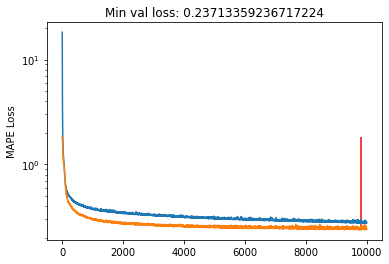

In [23]:
# for k,v in results['metrics'][9].items():
#     d =results['min_loss_val_dim'][0]
#     plt.plot(v, label=k)
#     plt.yscale('log')
#     plt.ylabel('MAPE Loss')
#     plt.title(f'Min val loss: {d}')
# plt.vlines(np.argmin(v), min(v), max(v), color='r')
# plt.show()

# Tune

In [ ]:
# trainable = lambda x: train_on_dataset('./merged_datasets_proj/proj_g.csv', intrinsic_dims, x, return_history=False)

# # hyperopt = HyperOptSearch(metric="score", mode="min")

# analysis = tune.run(
#     trainable,
#     config={'beta1':tune.uniform(0.5,0.9),
#           'beta2':tune.uniform(0.5,0.99),
#           'weight_decay':tune.grid_search([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]),
#             'lr':tune.grid_search([1e-1,1e-3]),
#             'hidden_dim': tune.grid_search([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]),
#             'dropout_rate1': tune.uniform(0.0,0.5),
#             'dropout_rate2': tune.uniform(0.0,0.5),
#             'dropout_rate3': tune.uniform(0.0,0.5),
#             'dropout_rate4': tune.uniform(0.0,0.5),
#             'dropout_rate5': tune.uniform(0.0,0.5),
#             'dropout_rate6': tune.uniform(0.0,0.5),
#             'dropout_rate7': tune.uniform(0.0,0.5),
#             'dropout_rate8': tune.uniform(0.0,0.5)},
#     resources_per_trial={'gpu': 1},
#     num_samples=5
#     )

In [ ]:
# ls /home/ibulygin/ray_results/lambda_2021-02-11_15-34-56/lambda_8c66e_00000_0_beta1\=0.61925,beta2\=0.59225,dropout_rate1\=0.040394,dropout_rate2\=0.34461,dropout_rate3\=0.20738,dropout_rate4\=_2021-02-11_15-34-56

In [ ]:
paths = [os.path.join(root,path) for path in os.listdir(root)]
results = []
for path in tqdm_notebook(paths):
    results.append(train_on_dataset(path, 
                                    intrinsic_dims, 
                                    config=default_config, 
                                    choose_one_dim=True, 
                                    return_history=True))

label2path = {}
datasets_result = {}
for path, result in zip(paths, results):
    label = path.split('/')[-1].split('.')[0]
    label2path[label] = path
    datasets_result[label] = result

# Results

In [ ]:
for k,v in datasets_result.items():
    
    min_loss_val_dim = np.array(v['min_loss_val_dim'])
    metrics_dict = v['metrics']
    ae_list = v['model']
    dim_range = v['dim_range']
    
    if len(dim_range) > 1:
        
        recommended_intrinsic_dims = intrinsic_dims[label2path[k]]
        ind = np.intersect1d(dim_range, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
        
        plt.figure()
        plt.plot(dim_range, min_loss_val_dim)
        plt.vlines(int_dims[[0,-1]], min_loss_val_dim.min(), min_loss_val_dim.max(), 'r', alpha=0.5)
        plt.xlabel('latent dim')
        plt.ylabel('MAPE')
        plt.title(k)
        
        ae=ae_list
    else:
        print(f'For {k}, dim={dim_range}, min_val_loss {min_loss_val_dim} achieved')
        ae=ae_list[0]
        
    if SAVE:
        print('Saving...')
        # make embedding
        data = np.genfromtxt(label2path[k], delimiter=';')
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        embedding_all, _ = ae(torch.from_numpy(data_scaled).cuda().float())
        embedding_all = embedding_all.detach().cpu().numpy()

        if MERGED:
            np.save(f'./merged_datasets_transformed/{k}_ae', embedding_all)
        else:
            orig_indexes = np.arange(data.shape[0])
            remained_items_mask = np.ones_like(orig_indexes)
            
            v_prev = 0
            item_iter = 0
            for dataset_name,v in datasets_nums.items():
                n_items = sum(remained_items_mask[v_prev:v_prev+v])
                np.save(f'./separate_datasets_transformed/{dataset_name}_{k}_ae', embedding_all[item_iter:item_iter+n_items])
                v_prev += v
                item_iter += n_items

### Merged 

Saving...For proj_f, dim=[8], min_val_loss [0.20790944] achieved  
For proj_g, dim=[9], min_val_loss [0.2425641] achieved  
For proj_o, dim=[6], min_val_loss [0.11661357] achieved  